In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget http://sereja.me/f/universum_compressed.tar
!tar xf universum_compressed.tar

--2022-03-19 15:39:07--  http://sereja.me/f/universum_compressed.tar
Resolving sereja.me (sereja.me)... 213.159.215.132
Connecting to sereja.me (sereja.me)|213.159.215.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72028160 (69M) [application/x-tar]
Saving to: ‘universum_compressed.tar’

universum_compresse 100%[===================>]  68.69M  7.67MB/s    in 16s     

2022-03-19 15:39:24 (4.28 MB/s) - ‘universum_compressed.tar’ saved [72028160/72028160]



In [3]:
import os
from PIL import Image

class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass
                #print('Could not load image:', filename)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        return X, Y

In [4]:
transform_all = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

def to_grayscale(x):
    return 1 - (x[0] * 0.299 + x[1] * 0.587 + x[2] * 0.114).view(1, 128, 128)


In [5]:
from tqdm.auto import tqdm

dataset = ColorizationDataset('universum-photos', to_grayscale, transform_all)
loader = DataLoader(dataset, batch_size=10, shuffle=True)

  0%|          | 0/1254 [00:00<?, ?it/s]

In [6]:
def to_numpy_image(img):
    return img.detach().cpu().view(3, 128, 128).transpose(0, 1).transpose(1, 2).numpy()

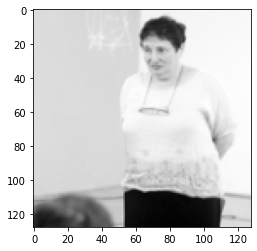

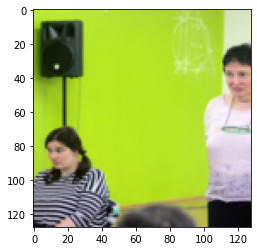

In [7]:
plt.imshow(dataset[0][0].permute(1, 2, 0).reshape(128, 128))
plt.set_cmap('Greys')
plt.show()
plt.imshow(dataset[0][1].permute(1,2,0))
plt.show()

In [8]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, X):
        return self.model(X)



In [9]:
class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.before_repeat = nn.Sequential(
            Block(1, 32),
            nn.MaxPool2d(2,2),
            Block(32, 128),
            nn.Upsample(scale_factor=2, mode='nearest'),
            Block(128, 256),
            nn.MaxPool2d(2,2),
            Block(256, 256),
            nn.Upsample(scale_factor=2, mode='nearest'),
            Block(256, 256),
            nn.MaxPool2d(2,2),
            Block(256, 256),
            nn.MaxPool2d(2,2),
            Block(256, 256),
            nn.MaxPool2d(2,2),
            Block(256, 256),
            nn.Upsample(scale_factor=2, mode='nearest'),
            Block(256, 256),  
            nn.Upsample(scale_factor=2, mode='nearest'),
            Block(256, 64), 
            nn.Upsample(scale_factor=2, mode='nearest'),
            Block(64, 16), 
        )

        self.after_repeat = nn.Sequential(
            Block(17, 8),
            Block(8, 3),
            nn.Sigmoid()
        )
    def forward(self, X):
        output = self.before_repeat(X)
        #print(output.shape, X.shape)
        output = torch.cat((output, X), 1)
        return self.after_repeat(output)

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Colorizer().to(device)

In [11]:
if True:
    model = torch.load('/content/model_weights.bin')

In [190]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
criterion = nn.L1Loss()
epochs = 10 # тут это стоит условно, я обучал примерно на 150 эпохах

  0%|          | 0/10 [00:00<?, ?it/s]

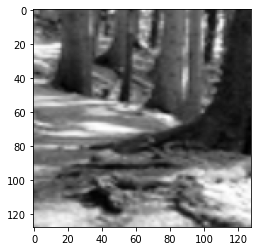

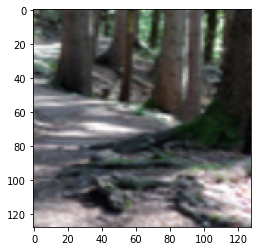

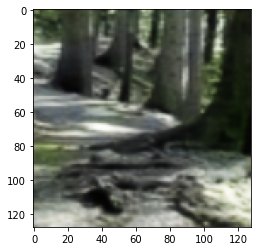

  0%|          | 0/102 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Loss per epoch 1 : 0.037357102549981834


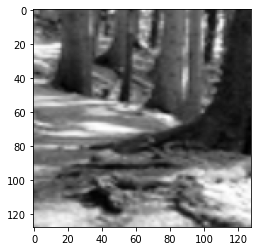

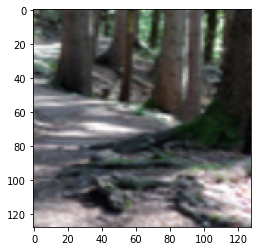

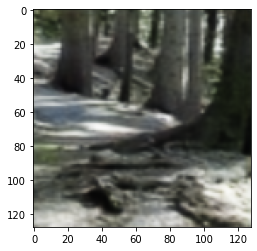

  0%|          | 0/102 [00:00<?, ?it/s]

Loss per epoch 2 : 0.03795646063472126


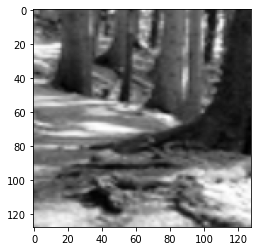

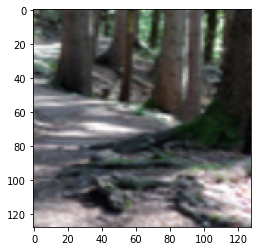

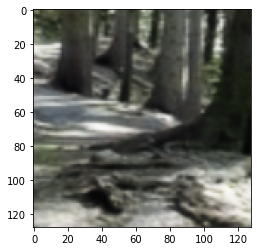

  0%|          | 0/102 [00:00<?, ?it/s]

Loss per epoch 3 : 0.03798175436974156


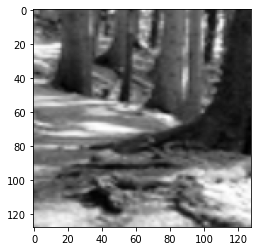

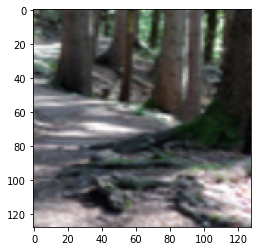

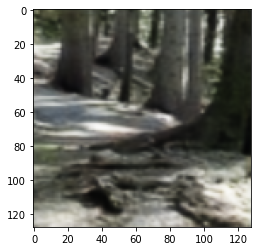

  0%|          | 0/102 [00:00<?, ?it/s]

Loss per epoch 4 : 0.03735959332655458


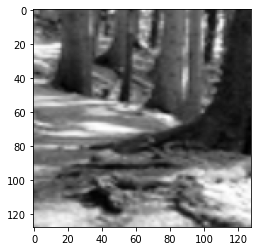

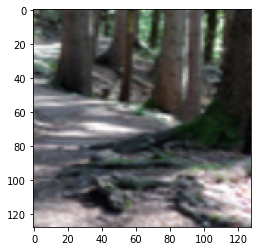

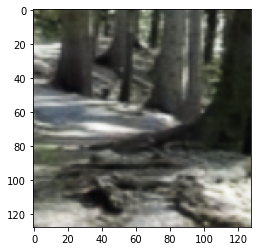

  0%|          | 0/102 [00:00<?, ?it/s]

Loss per epoch 5 : 0.03782790619879961


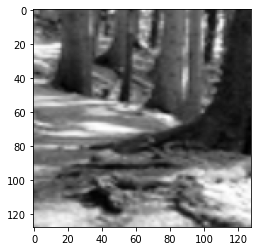

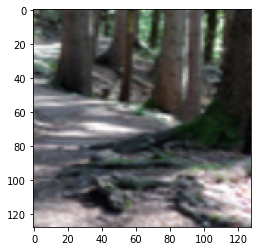

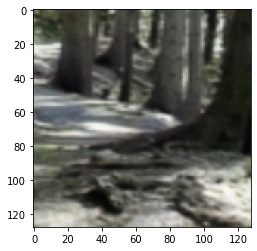

  0%|          | 0/102 [00:00<?, ?it/s]

Loss per epoch 6 : 0.03827011722194798


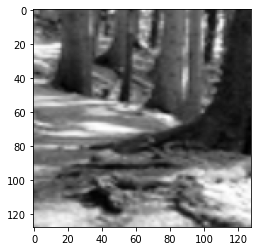

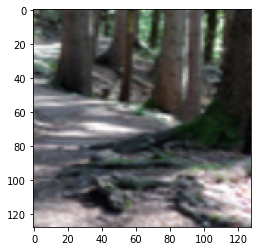

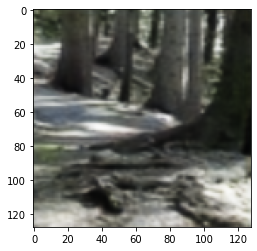

  0%|          | 0/102 [00:00<?, ?it/s]

Loss per epoch 7 : 0.03763502403436338


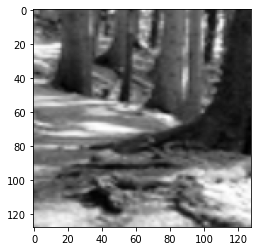

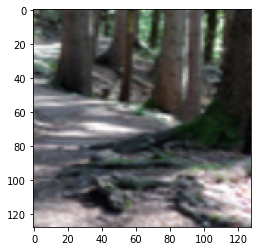

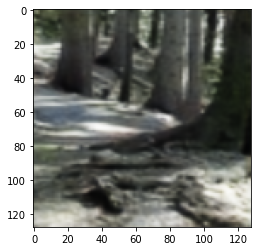

  0%|          | 0/102 [00:00<?, ?it/s]

Loss per epoch 8 : 0.03816213190336438


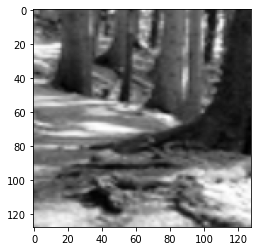

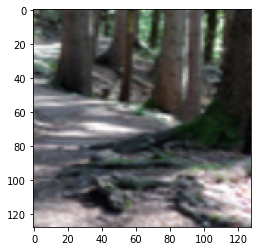

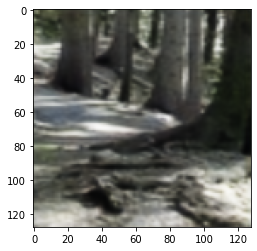

  0%|          | 0/102 [00:00<?, ?it/s]

Loss per epoch 9 : 0.03744789110679252


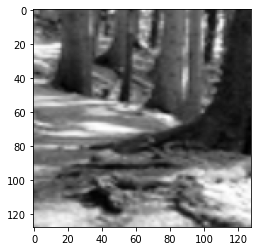

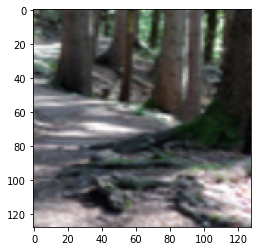

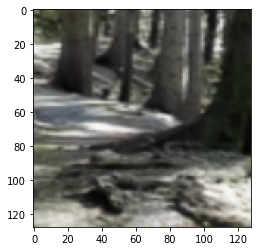

  0%|          | 0/102 [00:00<?, ?it/s]

Loss per epoch 10 : 0.037903714998095646


In [191]:
A, B = dataset[300]

img_test_bw = A.permute(1, 2, 0).reshape(128, 128)
img_test_col = (B.permute(1,2,0))


for epoch in tqdm(range(epochs)):
    model.eval()
    colorized = model(img_test_bw.reshape((1, 1, 128, 128)).to(device))
    plt.imshow(img_test_bw)
    plt.set_cmap('Greys')
    plt.show()
    plt.imshow(img_test_col)
    plt.show()
    plt.imshow(colorized[0].permute(1,2,0).cpu().detach().numpy())
    plt.show()    
    
    model.train()
    sum_loss = 0
    cnt_steps = 0
    for x, y in tqdm(loader):
        optimizer.zero_grad()
        colorized = model(x.to(device))
        loss = criterion(colorized.to(device),  y.to(device))
        sum_loss += loss.item()
        cnt_steps += 1
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 5.0)
        optimizer.step()
    torch.save(model, '/content/model_weights.bin')
    print(f'Loss per epoch {epoch + 1} : {sum_loss / cnt_steps}')
    

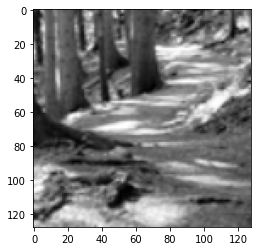

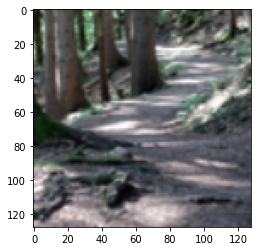

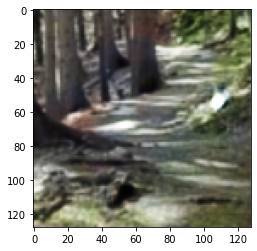

In [12]:
A, B = dataset[300]

img_test_bw = A.permute(1, 2, 0).reshape(128, 128)
img_test_col = (B.permute(1,2,0))


colorized = model(img_test_bw.reshape((1, 1, 128, 128)).to(device))
plt.imshow(img_test_bw)
plt.set_cmap('Greys')
plt.show()
plt.imshow(img_test_col)
plt.show()
plt.imshow(colorized[0].permute(1,2,0).cpu().detach().numpy())
plt.show()

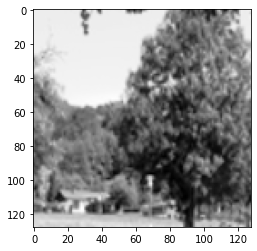

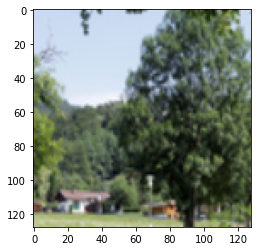

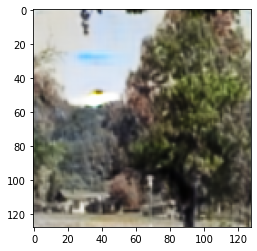

In [16]:
A, B = dataset[304]

img_test_bw = A.permute(1, 2, 0).reshape(128, 128)
img_test_col = (B.permute(1,2,0))


colorized = model(img_test_bw.reshape((1, 1, 128, 128)).to(device))
plt.imshow(img_test_bw)
plt.set_cmap('Greys')
plt.show()
plt.imshow(img_test_col)
plt.show()
plt.imshow(colorized[0].permute(1,2,0).cpu().detach().numpy())
plt.show()

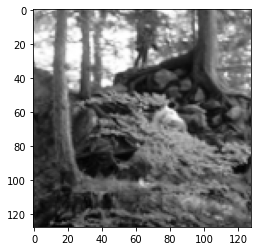

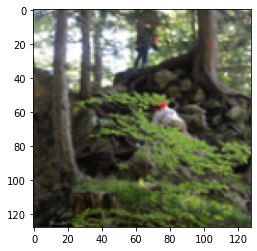

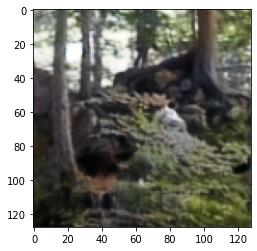

In [17]:
A, B = dataset[305]

img_test_bw = A.permute(1, 2, 0).reshape(128, 128)
img_test_col = (B.permute(1,2,0))


colorized = model(img_test_bw.reshape((1, 1, 128, 128)).to(device))
plt.imshow(img_test_bw)
plt.set_cmap('Greys')
plt.show()
plt.imshow(img_test_col)
plt.show()
plt.imshow(colorized[0].permute(1,2,0).cpu().detach().numpy())
plt.show()

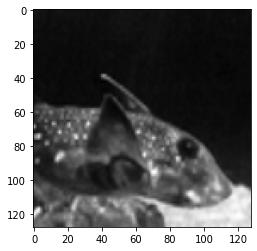

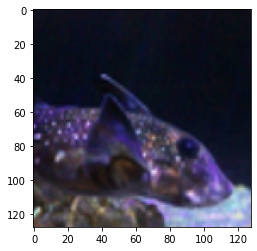

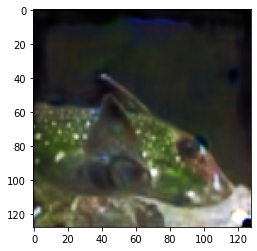

In [27]:
A, B = dataset[423]

img_test_bw = A.permute(1, 2, 0).reshape(128, 128)
img_test_col = (B.permute(1,2,0))


colorized = model(img_test_bw.reshape((1, 1, 128, 128)).to(device))
plt.imshow(img_test_bw)
plt.set_cmap('Greys')
plt.show()
plt.imshow(img_test_col)
plt.show()
plt.imshow(colorized[0].permute(1,2,0).cpu().detach().numpy())
plt.show()

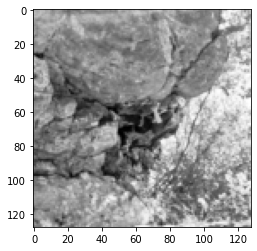

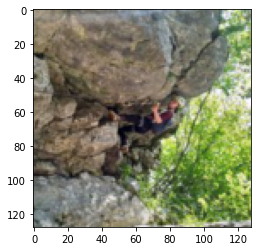

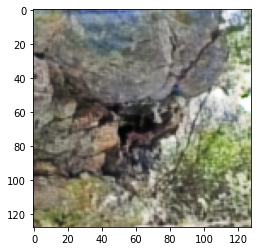

In [82]:
A, B = dataset[799]

img_test_bw = A.permute(1, 2, 0).reshape(128, 128)
img_test_col = (B.permute(1,2,0))


colorized = model(img_test_bw.reshape((1, 1, 128, 128)).to(device))
plt.imshow(img_test_bw)
plt.set_cmap('Greys')
plt.show()
plt.imshow(img_test_col)
plt.show()
plt.imshow(colorized[0].permute(1,2,0).cpu().detach().numpy())
plt.show()

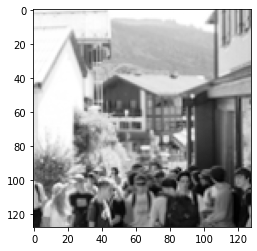

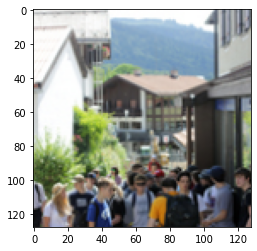

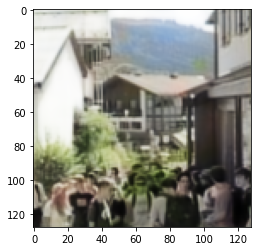

In [112]:
A, B = dataset[211]

img_test_bw = A.permute(1, 2, 0).reshape(128, 128)
img_test_col = (B.permute(1,2,0))


colorized = model(img_test_bw.reshape((1, 1, 128, 128)).to(device))
plt.imshow(img_test_bw)
plt.set_cmap('Greys')
plt.show()
plt.imshow(img_test_col)
plt.show()
plt.imshow(colorized[0].permute(1,2,0).cpu().detach().numpy())
plt.show()

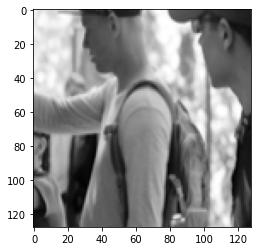

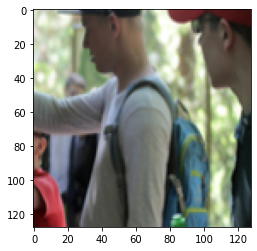

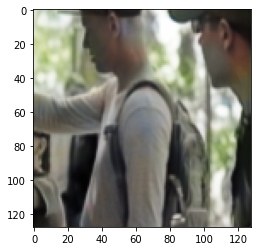

In [138]:
A, B = dataset[186]

img_test_bw = A.permute(1, 2, 0).reshape(128, 128)
img_test_col = (B.permute(1,2,0))


colorized = model(img_test_bw.reshape((1, 1, 128, 128)).to(device))
plt.imshow(img_test_bw)
plt.set_cmap('Greys')
plt.show()
plt.imshow(img_test_col)
plt.show()
plt.imshow(colorized[0].permute(1,2,0).cpu().detach().numpy())
plt.show()

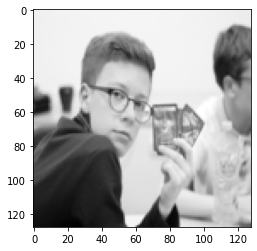

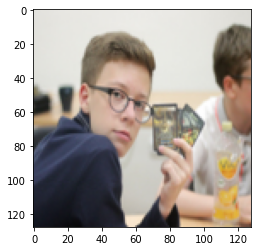

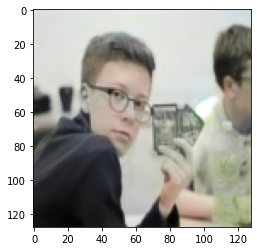

In [186]:
A, B = dataset[103]

img_test_bw = A.permute(1, 2, 0).reshape(128, 128)
img_test_col = (B.permute(1,2,0))


colorized = model(img_test_bw.reshape((1, 1, 128, 128)).to(device))
plt.imshow(img_test_bw)
plt.set_cmap('Greys')
plt.show()
plt.imshow(img_test_col)
plt.show()
plt.imshow(colorized[0].permute(1,2,0).cpu().detach().numpy())
plt.show()